# Zernike Polynomial Evaluation

This notebook compares different methods for evaluating the radial part of the Zernike polynomials, in terms of both speed and accuracy

The two primary methods we consider are direct polynomial evaluation using Horner's method and an evaluation scheme based on a recurrence relation for Jacobi polynomials.

The radial part of the Zernike polynomials is given by
\begin{equation}
Z_{l,m}(\rho) = \sum_{s=0}^{(l-|m|)/2} \frac{(-1)^s (l-s)!}{s![\frac{1}{2}(l+|m|)-s]![\frac{1}{2}(l+|m|)-s]!}\rho^{l-2s}
\end{equation}

Because the coefficient of rho is made up of entirely interger operations, it can be evaluated quickly and exactly to arbitrary orders (recall that python natively supports artibtrary length integer arithmetic). These coefficients can then be evaluated using Horner's method. This is done in the `zernike_radial_poly` function.

The other approach uses the fact that the above equation can be written as

\begin{equation}
Z_{l,m}(\rho) = (-1)^{(l-m)/2} \rho^m  P_{(l-m)/2}^{m, 0} (1 - 2 \rho^2)
\end{equation}
Where $P_{n}^{\alpha, \beta}$ is a Jacobi polynomial. This allows us to use stable recurrence relations for the Jacobi polynomials, as is done in the `zernike_radial` function.

In [45]:
import numpy as np
import mpmath
import matplotlib
import matplotlib.pyplot as plt
import desc.plotting
from desc.basis import ZernikePolynomial, zernike_radial, zernike_radial_poly, polyder_vec, zernike_radial_coeffs

In [46]:
basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
r = np.linspace(0,1,1000)

Here we time the evaluation for a basis set containing 676 modes on a grid of 1000 points, for derivative orders 0 thru 3. (note the `block_until_ready` is needed to get [accurate timing with jax](https://jax.readthedocs.io/en/latest/async_dispatch.html))

In [47]:
print("zerinke_radial, 0th derivative")
%time zr0 = zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
print("zerinke_radial, 1st derivative")
%time zr1 = zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
print("zerinke_radial, 2nd derivative")
%time zr2 = zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
print("zerinke_radial, 3rd derivative")
%time zr3 = zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()

zerinke_radial, 0th derivative
CPU times: user 973 ms, sys: 47.7 ms, total: 1.02 s
Wall time: 791 ms
zerinke_radial, 1st derivative
CPU times: user 700 ms, sys: 9.58 ms, total: 709 ms
Wall time: 273 ms
zerinke_radial, 2nd derivative
CPU times: user 979 ms, sys: 37.8 ms, total: 1.02 s
Wall time: 377 ms
zerinke_radial, 3rd derivative
CPU times: user 1.62 s, sys: 267 µs, total: 1.62 s
Wall time: 571 ms


In [49]:
print("zerinke_radial_poly, 0th derivative")
%time zp0 = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=0)
print("zerinke_radial_poly, 1st derivative")
%time zp1 = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=1)
print("zerinke_radial_poly, 2nd derivative")
%time zp2 = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=2)
print("zerinke_radial_poly, 3rd derivative")
%time zp3 = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=3)

zerinke_radial_poly, 0th derivative
CPU times: user 2.54 s, sys: 640 ms, total: 3.18 s
Wall time: 3.19 s
zerinke_radial_poly, 1st derivative
CPU times: user 2.51 s, sys: 598 ms, total: 3.11 s
Wall time: 3.13 s
zerinke_radial_poly, 2nd derivative
CPU times: user 2.54 s, sys: 531 ms, total: 3.07 s
Wall time: 3.08 s
zerinke_radial_poly, 3rd derivative
CPU times: user 2.38 s, sys: 671 ms, total: 3.05 s
Wall time: 3.07 s


We see that the implementation using Jacobi polynomial recurrence relation is significantly faster, despite the overhead from the JAX just-in-time compiler

For accuracy comparison, we will also evaluate the Zernike radial polynomials in extended precision (100 digits of accuracy) and treat this as the "true" value.

In [50]:
mpmath.mp.dps = 100
c = zernike_radial_coeffs(basis.modes[:,0], basis.modes[:,1], exact=True)

print("zerinke_radial_exact, 0th derivative")
%time zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
print("zerinke_radial_exact, 1st derivative")
%time zt1 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c,1)]).T
print("zerinke_radial_exact, 2nd derivative")
%time zt2 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c,2)]).T
print("zerinke_radial_exact, 3rd derivative")
%time zt3 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c,3)]).T

zerinke_radial_exact, 0th derivative
CPU times: user 1min 48s, sys: 29.6 ms, total: 1min 48s
Wall time: 1min 49s
zerinke_radial_exact, 1st derivative
CPU times: user 1min 47s, sys: 55.1 ms, total: 1min 47s
Wall time: 1min 47s
zerinke_radial_exact, 2nd derivative
CPU times: user 1min 47s, sys: 59.1 ms, total: 1min 47s
Wall time: 1min 47s
zerinke_radial_exact, 3rd derivative
CPU times: user 1min 46s, sys: 67 ms, total: 1min 46s
Wall time: 1min 46s


Next we can plot the error resulting from the two evaluation methods (polynomial evaluation and jacobi recurrence relation) vs the true solution computed in exact arithmetic. We plot the max absolute error as well as the max relative error over $\rho \in (0,1)$ for each derivative order.

In [51]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.logspace(-16, 0, 17)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

## Absolute Error

### 0th derivative

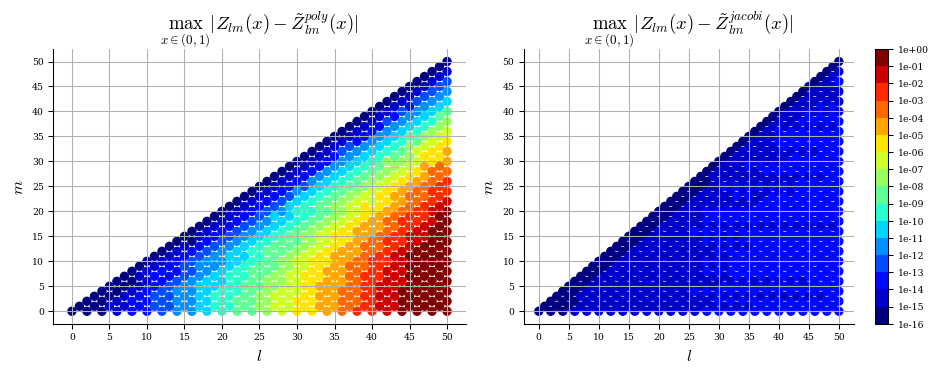

In [52]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp0-zt0),axis=0), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr0-zt0),axis=0), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title('$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)|$', fontsize=14)
ax[1].set_title('$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{jacobi}(x)|$', fontsize=14);

### 1st derivative

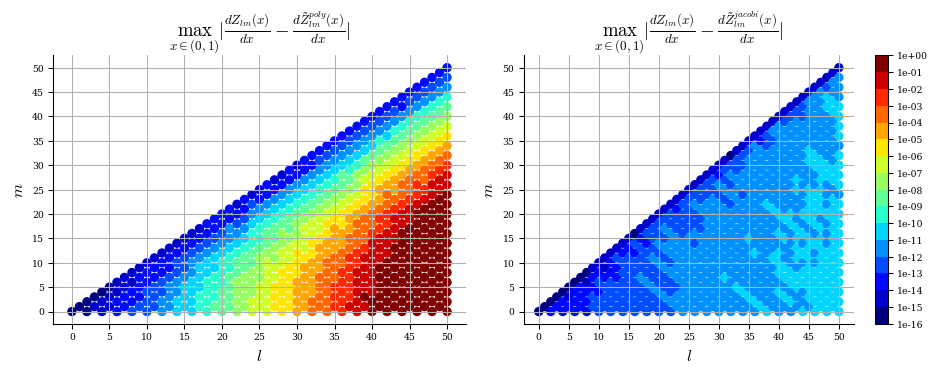

In [53]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp1-zt1),axis=0), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr1-zt1),axis=0), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title('$\max_{x \in (0,1)} |\\frac{dZ_{lm}(x)}{dx} - \\frac{d\\tilde{Z}_{lm}^{poly}(x)}{dx}|$', fontsize=14)
ax[1].set_title('$\max_{x \in (0,1)} |\\frac{dZ_{lm}(x)}{dx} - \\frac{d\\tilde{Z}_{lm}^{jacobi}(x)}{dx}|$', fontsize=14);

### 2nd derivative

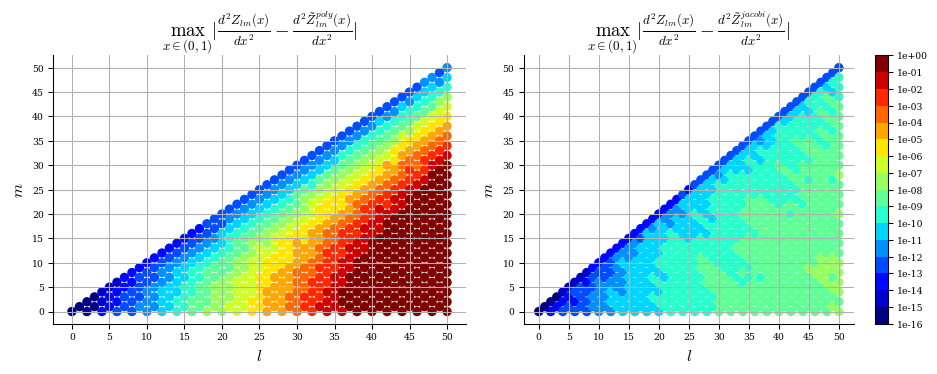

In [54]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp2-zt2),axis=0), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr2-zt2),axis=0), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title('$\max_{x \in (0,1)} |\\frac{d^2 Z_{lm}(x)}{dx^2} - \\frac{d^2 \\tilde{Z}_{lm}^{poly}(x)}{dx^2}|$', fontsize=14)
ax[1].set_title('$\max_{x \in (0,1)} |\\frac{d^2 Z_{lm}(x)}{dx^2} - \\frac{d^2 \\tilde{Z}_{lm}^{jacobi}(x)}{dx^2}|$', fontsize=14);

### 3rd derivative

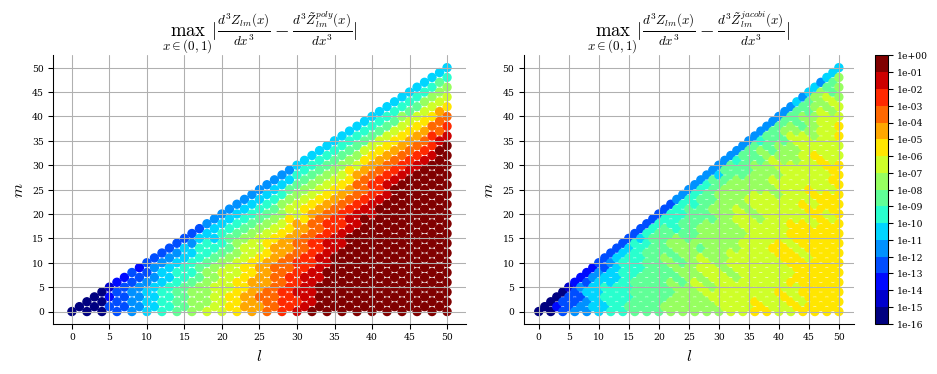

In [55]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp3-zt3),axis=0), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr3-zt3),axis=0), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title('$\max_{x \in (0,1)} |\\frac{d^3 Z_{lm}(x)}{dx^3} - \\frac{d^3 \\tilde{Z}_{lm}^{poly}(x)}{dx^3}|$', fontsize=14)
ax[1].set_title('$\max_{x \in (0,1)} |\\frac{d^3 Z_{lm}(x)}{dx^3} - \\frac{d^3 \\tilde{Z}_{lm}^{jacobi}(x)}{dx^3}|$', fontsize=14);

## Relative Error

### 0th derivative

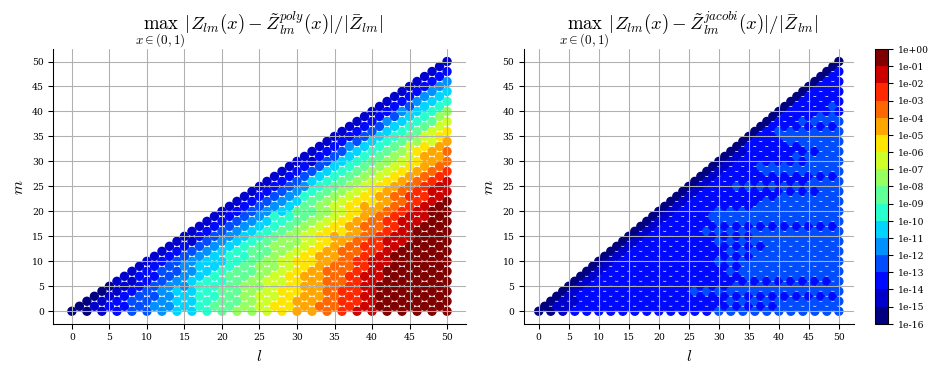

In [56]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp0-zt0),axis=0)/np.mean(abs(zt0)), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr0-zt0),axis=0)/np.mean(abs(zt0)), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title('$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)| / |\\bar{Z}_{lm}|$', fontsize=14)
ax[1].set_title('$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{jacobi}(x)| / |\\bar{Z}_{lm}|$', fontsize=14);

### 1st derivative

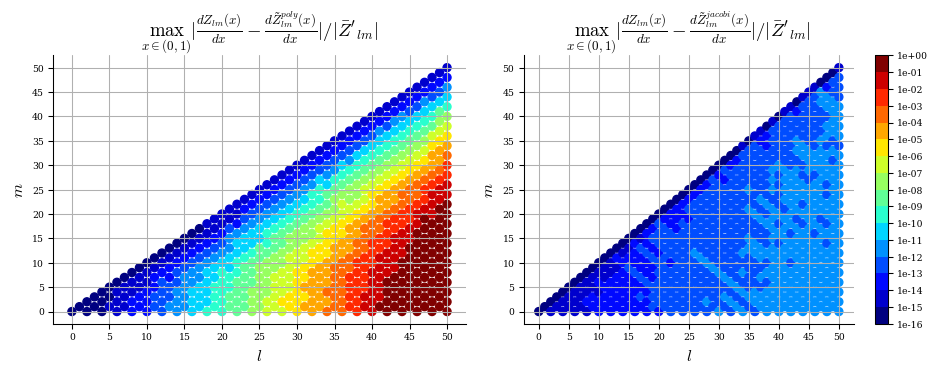

In [57]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp1-zt1),axis=0)/np.mean(abs(zt1)), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr1-zt1),axis=0)/np.mean(abs(zt1)), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title("$\max_{x \in (0,1)} |\\frac{dZ_{lm}(x)}{dx} - \\frac{d\\tilde{Z}_{lm}^{poly}(x)}{dx}| / |\\bar{Z}'_{lm}|$", fontsize=14)
ax[1].set_title("$\max_{x \in (0,1)} |\\frac{dZ_{lm}(x)}{dx} - \\frac{d\\tilde{Z}_{lm}^{jacobi}(x)}{dx}|/ |\\bar{Z}'_{lm}|$", fontsize=14);

### 2nd derivative

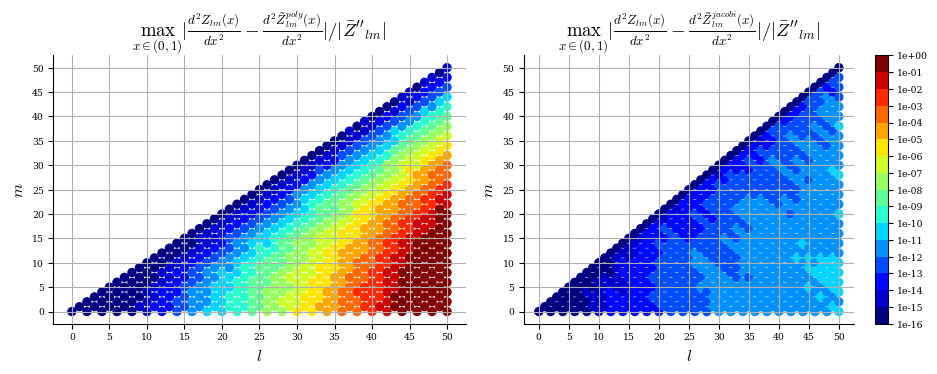

In [58]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp2-zt2),axis=0)/np.mean(abs(zt2)), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr2-zt2),axis=0)/np.mean(abs(zt2)), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title("$\max_{x \in (0,1)} |\\frac{d^2Z_{lm}(x)}{dx^2} - \\frac{d^2\\tilde{Z}_{lm}^{poly}(x)}{dx^2}| / |\\bar{Z}''_{lm}|$", fontsize=14)
ax[1].set_title("$\max_{x \in (0,1)} |\\frac{d^2Z_{lm}(x)}{dx^2} - \\frac{d^2\\tilde{Z}_{lm}^{jacobi}(x)}{dx^2}|/ |\\bar{Z}''_{lm}|$", fontsize=14);

### 3rd derivative

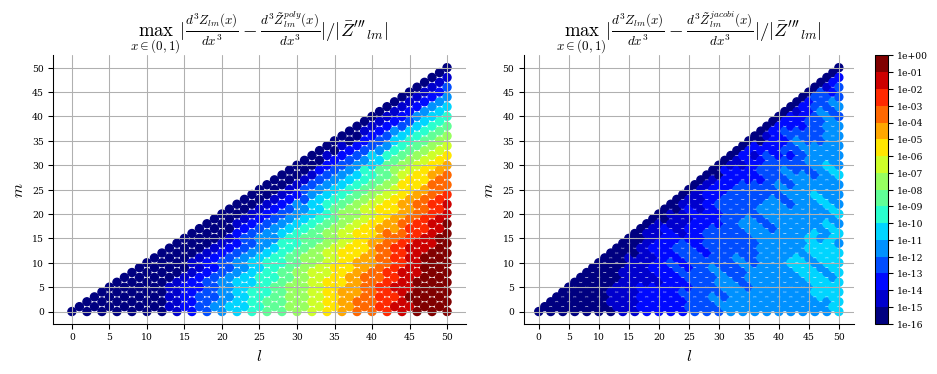

In [59]:
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(10,4))
im = ax[0].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zp3-zt3),axis=0)/np.mean(abs(zt3)), norm=norm, cmap=cmap)
im = ax[1].scatter(basis.modes[:,0],basis.modes[:,1],c=np.max(abs(zr3-zt3),axis=0)/np.mean(abs(zt3)), norm=norm, cmap=cmap)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0,55,5))
ax[0].set_yticks(np.arange(0,55,5))
ax[1].set_xticks(np.arange(0,55,5))
ax[1].set_yticks(np.arange(0,55,5))
ax[0].set_xlabel('$l$', fontsize=12)
ax[0].set_ylabel('$m$', fontsize=12)
ax[1].set_xlabel('$l$', fontsize=12)
ax[1].set_ylabel('$m$', fontsize=12)
ax[0].set_title("$\max_{x \in (0,1)} |\\frac{d^3Z_{lm}(x)}{dx^3} - \\frac{d^3\\tilde{Z}_{lm}^{poly}(x)}{dx^3}| / |\\bar{Z}'''_{lm}|$", fontsize=14)
ax[1].set_title("$\max_{x \in (0,1)} |\\frac{d^3Z_{lm}(x)}{dx^3} - \\frac{d^3\\tilde{Z}_{lm}^{jacobi}(x)}{dx^3}|/ |\\bar{Z}'''_{lm}|$", fontsize=14);

So in addition to being faster, the evaluation using the Jacobi recurrence relation is also significantly more accurate as the mode numbers increase, keeping absolute error less than $10^{-5}$ and relative error less than $10^{-9}$, while directly evaluating the polynomial leads to errors greater than 100\% for large $l$